Select a number of galaxies ($\sim 500$ for testing, $\gtrsim 50,000$ for good results) with intrinsic ellipticities taken from a uniform distribution of ellipticity ($\epsilon$), distortion (e), or axis ratio (q), as given by an option. Also draw the phase uniformly from 0-pi (note that the orientation angle $\phi$ is 0-$\pi$ but in this space you need to cover the whole 0-$2\pi$). Galaxy size is constant, gaussian profile.

For each galaxy:
    Apply an array of shears. Ex: g=\[0+0i, 0.04+0i, -0.04+0i, 0+0.04i, 0-0.04i\], but variable.
    Apply Gaussian PSF and Gaussian noise. The same noise realisation for each shear value for a given galaxy, but different for each galaxy. 
    Rotate intrinsic shape by $n_{rot}$ times, where $n_{rot}$ is a variable. This gets treated as a separate galaxy with its own noise realisation.
    
Now we average: $\hat g = \langle \epsilon \rangle |_g$, converting from distortion to shear as appropriate. Only average galaxies with the same applied shear.
Then we plot $\hat g_1$ vs $g_1$, the observed shear vs real shear, and similarly for $g_2$. Remember to plot errors. Ideally there should be a straight line relation $(1+m_1)g_1 + c_1$ and similar. Fit with scipy curvefit to get parameters. Finally, repeat for different SNR, and plot SNR vs $m$. 

This notebook is not complete or fully tested. It is an R&D notebook from which I am borrowing code for other applications.

In [ ]:
#Import libraries
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import galsim
from scipy.optimize import curve_fit
import time
import cProfile
import cPickle
import emcee

from galsim.gsparams import GSParams
from galsim.hsm import HSMParams

In [2]:
#Constants
shape_distribution = ['ellipticity','distortion','axis_ratio']

In [3]:
#Simulation options
distribution_key = 0 #choose shape_distribution from above
matchRotNans = True #All rotated images of a galaxy are nan if one of them is nan, if True
nrot = 2 #Number of images per galaxy ie 1 is no rotations, 2 is a 0 and 90 degree rot, etc
ngal = 1000 #Number of galaxies to simulate
shearList = [(0,0),(0.04,0),(-0.04,0),(0,0.04),(0,-0.04)] #list of shears to apply
g1shear = [shear[0] for shear in shearList]
g2shear = [shear[1] for shear in shearList]

gsparams = galsim.GSParams(maximum_fft_size=12288)
hsmp = galsim.hsm.HSMParams(max_mom2_iter=800) #double the default value

#Parameters of the galaxy flux distribution
m_min, m_max = 19, 25 #min, max magnitudes
m0 = 25
#Starting parameters for walkers; other MCMC parameters can be adjusted below
init_add, init_mult = int(np.mean((m_min, m_max))), (m_max - m_min)/4.

#Parameters of the galaxy ellipticity function
epsilon0 = 0.35
distortion_cutoff = 0.9
shape_parameter_type = shape_distribution[distribution_key]

#Other parameters of the galaxy population
disk_n = 0.5  #n for Sersic profile; 1/2 for Gaussian
disk_re = 0.8 #half-light radius, as

#Parameters of the PSF
psf_sigma = 0.5 #as
pixel_scale = 0.3 #as/px

#Parameters of the noise
#snrArr = np.linspace(100,200,6) #array of desired SNRs for the Gaussian noise
snrArr = np.array([0]) #Placeholder
noise_sigma = 0.01 #Gives SNR ~300 for m = 20, m0=25

#Gaussian PSF
psf = galsim.Gaussian(flux=1.,sigma=psf_sigma)
image_psf=psf.drawImage(scale=pixel_scale)



For magnitude distribution, use

log_10 (N) = -8.85 + 0.71*m - 0.008*m*m for m from 19 to 28. You can use the zero point (m_0) as 25. Adjust the noise level so m=20 corresponds to SNR ~ 300.

For ellipticity (\epsilon) type, use Eq. 4 of http://arxiv.org/abs/1502.01883

In [4]:
def mag_hist_power_law(x,norm):
      return norm* 10**(-8.85177133 +  0.716305260*x -0.00832345561*x*x)

from scipy import interpolate
## fnc is any callable functions defined
def draw_samples_specified_distribution(nsamples, fnc, z,*args):
    #zmin=1e-5
    #zmax=20
    #z = numpy.linspace(zmin,zmax) # Example indep variable
    fofz = fnc(z,*args)
    cdf_fofz = fofz.cumsum() # Next few steps to calculate CDF
    cdf_fofz -= cdf_fofz[0] # w/appropriate normalization
    cdf_fofz /= cdf_fofz[-1]
    max_val = np.where(cdf_fofz==1)[0].min()+1 #Nothing in CDF above 1
    cdf_fofz = cdf_fofz[:max_val] # cut off the trailing ones
    z = z[:max_val]
    model = interpolate.InterpolatedUnivariateSpline(cdf_fofz,z,k=4)
    np.random.seed(seed=10)
    samples = model(np.random.random(nsamples)) # Draw samples
    return samples

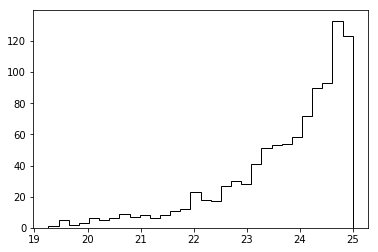

In [5]:
def magnitude(F,m0):
    #Convert from flux to magnitude
    return -2.5*np.log10(F)+m0
def flux(m,m0):
    #Convert from magnitude to flux
    return 10**((m-m0)/(-2.5))

magArr = np.linspace(m_min,m_max,10000)
mags = draw_samples_specified_distribution(ngal, mag_hist_power_law, magArr, 1)
fluxes = flux(mags, m0)
#Plot histogram
a=plt.hist(mags, 30, color="k", histtype="step")


In [6]:
distortion = np.random.rayleigh(epsilon0, size=ngal)
#Place cut on distortion as they do in Hoekstra et al 2015
while np.any(distortion>distortion_cutoff):
    high_dist = np.where(distortion>distortion_cutoff)  
    distortion[high_dist] = np.random.rayleigh(epsilon0, size=len(high_dist))
shape_magnitude = distortion

In [7]:
#Generate random numbers for intrinsic galaxy shapes
#shape_params = np.random.random((ngal,2))
phase = np.random.random(ngal)
shape_params = np.stack((shape_magnitude, phase)).transpose()

In [8]:
#Make catalog
#Galaxy ID, Flux/magnitude, size, sersic n, intrinsic ellipticity

galId = range(ngal)
flux = fluxes
size = [disk_re]*ngal
sersic = [disk_n]*ngal
shape1 = list(shape_params[:,0])
shape2 = list(shape_params[:,1] * np.pi)

input_cat = np.stack((galId,flux,size,sersic,shape1,shape2)).transpose()
header = 'galId flux size sersic shape1 shape2 nrot'
np.savetxt('../shear_bias_outputs/input_cat.txt',input_cat,delimiter=' ',header=header)

In [9]:
def intrinsic_shear(galaxy,shape_parameter_type,mag,ph):
    if shape_parameter_type == 'ellipticity':
        newGal = galaxy.shear(g=mag, beta=ph*galsim.radians)
    elif shape_parameter_type == 'distortion':
        newGal = galaxy.shear(e=mag, beta=ph*galsim.radians)
    elif shape_parameter_type == 'axis_ratio':
        newGal = galaxy.shear(q=mag, beta=ph*galsim.radians)
    else:
        raise ValueError, 'shape_parameter_type "%s" not recognized. Use one of the allowed keywords.' %shape_parameter_type
    return newGal

In [10]:
#load catalog
cat = np.loadtxt('../shear_bias_outputs/input_cat.txt', skiprows=1)
flux = cat[:,1]
disk_reArr, disk_nArr = cat[:,2],cat[:,3]
magArr,phArr = cat[:,4],cat[:,5]

#Generate galaxies
galaxies = [galsim.Sersic(disk_n,half_light_radius=disk_re,gsparams=gsparams) for (disk_re,disk_n) in zip(disk_reArr,disk_nArr)]
galaxies = [gal.withFlux(gal_flux) for gal,gal_flux in zip(galaxies,flux)]
galaxies = [intrinsic_shear(galaxy,shape_parameter_type,mag,ph) for galaxy,mag,ph in zip(galaxies,magArr,phArr)]

#Generate rotated galaxies, add to galaxy list
rotation_angle = [180./(nrot)*i for i in range(1,nrot)]
rot_gals = [gal.rotate(angle*galsim.degrees) for angle in rotation_angle for gal in galaxies]
galaxies += rot_gals

# rotation_angle = [180./(nrot)*i for i in range(0,nrot)]
# rot_gals = [[gal.rotate(angle*galsim.degrees) for angle in rotation_angle] for gal in galaxies]

In [11]:
#shear galaxies
shearedGals = np.array([[gal.shear(g1=shear[0],g2=shear[1]) for gal in galaxies] for shear in shearList])
#shearedGals (numShears, numGals)

# shearedGals = np.array([[[gal.shear(g1=shear[0],g2=shear[1]) for gal in subgal] for subgal in rot_gals] for shear in shearList])


In [137]:
#Measure shapes
#replace disk_re with catalog
def measureShape(noise_im, image_psf):
        results = galsim.hsm.EstimateShear(noise_im,image_psf,strict=False,\
                                           guess_sig_gal=disk_re/pixel_scale, guess_sig_PSF=psf_sigma/pixel_scale,\
                                           shear_est='REGAUSS', hsmparams = hsmp)
        if results.correction_status==0:
            return [results.corrected_e1, results.corrected_e2, results.corrected_shape_err,0]
        #if shape estimation unsuccessful
        else:
            if 'NaN' in results.error_message:
                em = -11
            elif 'adaptive' in results.error_message:
                em = -9
            elif 'min/max' in results.error_message:
                em = -7
            else:
                print results.error_message
                em = -999

            return [np.nan, np.nan, np.nan,em]
    
def addGaussianNoiseSNR(im,clean_im,snr):
    noise = galsim.GaussianNoise(sigma=1)
    im.addNoiseSNR(noise, snr, preserve_flux=True)
    noise_im = im - clean_im
    return noise_im

def addGaussianNoise(im,clean_im,sigma):
    noise = galsim.GaussianNoise(sigma=sigma)
    im.addNoise(noise)
    noise_im = im - clean_im
    return noise_im

In [138]:
startC,startT = time.clock(), time.time()
save_ims = False #CAREFUL making this True; it will expend all of your memory very rapidly
obs = []
shearedGalT = shearedGals.transpose()
#Iterate over rows of the same galaxy w/ different shears
noisyGals=[]
for galRowNum,galRow in enumerate(shearedGalT):
    gal_ims = []
    for i,gal in enumerate(galRow):
        #Convolve w/ PSF and draw image
        final = galsim.Convolve([gal, psf])
        if i==0:
            image = final.drawImage(scale=pixel_scale)
        else:
            image_shape = gal_ims[0].array.shape
            im_final = galsim.ImageF(*image_shape)
            image = final.drawImage(image=im_final, scale=pixel_scale)
        gal_ims.append(image)

    obs_snr = []
    #Loop through SNRs
    for snr in snrArr:
        #Add noise
        first = gal_ims[0].copy()
        #noise_im = addGaussianNoiseSNR(first, gal_ims[0], snr)
        noise_im = addGaussianNoise(first, gal_ims[0], noise_sigma)
        noisyImRow = [im + noise_im for im in gal_ims]
        if save_ims:
            noisyGals.append(noisyImRow)
        #Measure shape
        obsRow = [measureShape(noisyIm, image_psf) for noisyIm in noisyImRow]
        obs_snr.append(obsRow)

    obs.append(obs_snr)

obs = np.array(obs)
obs=np.stack([obs[ngal*i:ngal*(i+1)] for i in range(nrot)]) #Put rotated versions in new axis
#nrot, ngal, snr, shear, meas
obs = obs.transpose(2,1,0,3,4) #Get desired shape

error_message = obs[:,:,:,:,-1]
shape_err = obs[:,:,:,:,-2]
obs = obs[:,:,:,:,:-2] #remove shape error from obs
print obs.shape
#Save file
# outfile2 = open('../shear_bias_outputs/obs.pkl','wb')
# cPickle.dump(obs,outfile2)
# outfile2.close()

print 'clock time: %10.1f \n cpu time: %10.1f' % (time.clock()-startC,time.time()-startT)
print 'len(shearedGals) = ', shearedGals.size

#cProfile.run('a()',sort=1)

#obs shape:
#(#SNRs, ngal, nrot, #shears, 2)
#Axis 0: SNR
#Axis 1: Galaxy #
#Axis 2: Rotated versions
#Axis 3: Shear
#Axis 4: shape measurement: [e1corr, e2corr] or [nan, nan] in case of failure


(1, 1000, 2, 5, 2)
clock time:       35.9 
 cpu time:       36.1
len(shearedGals) =  10000


In [146]:
nanErr = [error_message==-11]
numIterErr = [error_message==-9]
minmaxErr = [error_message==-7]
otherErr = [error_message==-999]
print 'NaN Err: ',np.sum(nanErr), '\nnumIter Err: ', np.sum(numIterErr), '\nMin/Max Err: ', \
np.sum(minmaxErr), '\nOther Err: ', np.sum(otherErr)

NaN Err:  64 
numIter Err:  233 
Min/Max Err:  1 
Other Err:  0


In [65]:
def matchRotatedNans(obs):
    '''If any of the rotations of a single galaxy are nan, make all rotations nan'''
    tempObs = obs.transpose(0,1,3,2,4) #(SNR, ngal, shear, nrot, (e1, e2))
    for i in range(tempObs.shape[0]):
        for j in range(tempObs.shape[1]):
            for k in range(tempObs.shape[2]):
                if np.any(np.isnan(tempObs[i,j,k])):
                    for m in range(tempObs.shape[3]):
                        tempObs[i,j,k,m] = [np.nan] * tempObs[i,j,k,m].size
    obs = tempObs.transpose(0,1,3,2,4) 
    return obs

if matchRotNans:
    obs = matchRotatedNans(obs)

In [66]:
print obs.shape
print fluxes.shape
failed_fluxes = np.isnan(obs)
np.sum(failed_fluxes) / float(obs.size)

(1, 1000, 2, 5, 2)
(1000,)


0.0516

In [67]:
def nanav(array, weights, axis=None):
    '''Take weighted average of an array, ignoring nan values
       array: ndarray object. weights: array of same size, giving weights.
       axis: int giving axis to average along
       returns: array averaged along given axis, ignoring nans'''
    ma = np.ma.MaskedArray(array, mask=np.isnan(array))
    av = np.ma.average(ma, weights=weights, axis=axis)
    if isinstance(av, np.ndarray):
        if np.any(av.mask):
            raise ValueError, 'Average should not contain np.nan'
        else:
            return av.data
    else:
        return av

def findMeanShear(obs,weights):
    '''obs: array of measured distortions, shape (SNR, Galaxy#, nrot, Shear, (e1,e2))
       weights: array of weights
       Returns estimate of mean shear, shape (SNR, Shear, (g1,g2))'''
    distortionMean = nanav(obs,weights, axis=(1,2))
    distSqMean = np.nanmean(obs[:,:,:,:,0]**2 + obs[:,:,:,:,1]**2)/2.
    mean = distortionMean / (2 * (1-distSqMean)) #Formula for approximate shear
    return mean

#Keep rotated pairs together when bootstrapping

def bootstrapShear(obs,weights,nBootstrap):    
    '''obs,weights: as above. nBootstrap: int, number of times to resample
       Returns array of shape (nBootstrap,SNR,shear,(g1,g2)) giving samples of mean shear'''
    size=obs.shape[1]
    shearSamples = []
    for i in xrange(nBootstrap):
        np.random.seed(seed=i) #seed=None to use a random seed
        randNums = np.random.random(size)
        ncounts, bin_edges = np.histogram(randNums, bins=size, range=(0,1))
        ncounts = ncounts.reshape(1,len(ncounts),1,1,1)
        for i in [0,2,3,4]:
            ncounts = ncounts.repeat(weights.shape[i],axis=i)

        newWeights = weights * ncounts
        shearSample = findMeanShear(obs, newWeights)
        shearSamples.append(shearSample)
    shearSamples = np.stack(shearSamples)
    return shearSamples
    

In [85]:
mates = np.reshape(weights, weights.shape+(1,))
mates = np.repeat(mates, obs.shape[-1], axis=-1)


(1, 1000, 2, 5, 2)


In [ ]:
#define weights
shape_noise2 = np.var(magArr) #shape noise is variance of input ellipticities

weights = 1/(shape_noise2 + shape_err**2)
weights[np.isnan(weights)] = 0 #Set weight to zero if nan
weights = np.reshape(weights, weights.shape + (1,))
weights = np.repeat(weights, obs.shape[-1], axis=-1)

#weights = np.ones_like(obs)

In [86]:
startC,startT = time.clock(), time.time()

#Find weighted g1 and g2 from e1, e2
meanShear= findMeanShear(obs,weights)
#Use bootstrap method to resample and derive an error on the shear values
size = obs.shape[1]
nBootstrap = int(size*np.log(size)**2)
shearSamples = bootstrapShear(obs,weights,nBootstrap)
errShear = np.std(shearSamples,axis=0) / np.sqrt(nBootstrap)
meanShearBootstrap = np.mean(shearSamples,axis=0)
print 'clock time: %10.1f \n cpu time: %10.1f' % (time.clock()-startC,time.time()-startT)

#Combine mean and err into a single array
res = np.stack((meanShear,errShear)).transpose(3,1,2,0)

#res Shape: (measurements, SNRs, shears, (mean, err))
#plt.hist(shearSamples[:,0,0,0],bins=11)

(1, 1000, 2, 5, 2)
(1, 1000, 2, 5, 2)
clock time:       66.1 
 cpu time:       66.6


In [87]:
def lin(x,m,b):
    return m*x+b

def fitline(shear,data,err):
    fitparam, fiterr = curve_fit(lin,shear,data,p0=[1,0],sigma=err)
    return fitparam

def getFitParameters(shearList,fullRes):
    '''
    fullRes is an array of shape (measurements, SNRs, shears, (mean, err))
    shearList is a list of 2-tupes of true shear
    '''
    #Iterate over measurements
    g1shear = [shear[0] for shear in shearList]
    g2shear = [shear[1] for shear in shearList]
    shear=(g1shear,g2shear)
    fullParamArr=[]
    for i,res in enumerate(fullRes[:2]):
        fitParamArr = []
        #Iterate over SNRs
        for subRes in res:
            fitparams = fitline(shear[i],subRes[:,0],subRes[:,1]) 
            fitParamArr.append(fitparams)
        fullParamArr.append(fitParamArr)
    return np.array(fullParamArr) #Shape (2 (g1, g2), #SNRs, 2 (slope, intercept of line))

In [88]:
#Fits nBootstrap * nShear * 2 (g1,g2) lines
#~1.7s / 10k fits
def bootstrapM(shearSamples,shearList):
    '''shearSamples as above. shearList is a list of 2-tuples of true shear
       Return array of shape (nBootstrap, 2 (g1,g2), SNRs)'''
    mSamples=[]
    sigma = np.ones_like(shearSamples)[0] #Use 1 for all errors (same as no error)
    for sample in shearSamples:
        sampleRes = np.stack([sample,sigma]).transpose(3,1,2,0)
        gparams= getFitParameters(shearList,sampleRes)       
        mSamples.append(gparams[:,:,0])
    mSamples=np.stack(mSamples)
    return mSamples

sh=shearSamples.shape
estTime = sh[0]*sh[1]*sh[2] * (1.7/10000.)
print 'Estimated time: %10.1f seconds' % estTime
startC,startT = time.clock(), time.time()
mSamples = bootstrapM(shearSamples,shearList) #shape: numSamples, 2 (g1,g2), SNRs
mStd = np.std(mSamples,axis=0) / np.sqrt(nBootstrap)
mMeanBootstrap = np.mean(mSamples,axis=0)
#mStd shape: ((g1,g2), SNRs)

mMean = getFitParameters(shearList,res)[:,:,0]
print 'clock time: %10.1f \n cpu time: %10.1f' % (time.clock()-startC,time.time()-startT)


Estimated time:       40.6 seconds
clock time:       38.0 
 cpu time:       38.3


(47717, 2, 1)


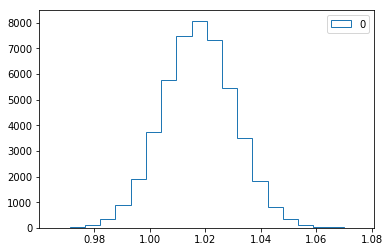

In [89]:
print mSamples.shape
for i in range(len(snrArr)):
    plt.hist(mSamples[:,0,i],bins=20,histtype='step',label=str(snrArr[i]))
plt.legend()
    

In [90]:
#get mean from bootstrap, compare to true mean
#keep option to kill all rotations if one of them fails

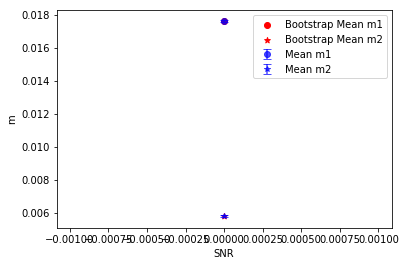

In [91]:
plt.errorbar(snrArr,mMean[0]-1,yerr=mStd[0],fmt='o',c='b',capsize=4,label='Mean m1',alpha=0.7,marker='o')
plt.scatter(snrArr,mMeanBootstrap[0]-1,c='r',label='Bootstrap Mean m1',marker='o')
plt.xlabel('SNR')
plt.ylabel('m')

plt.errorbar(snrArr,mMean[1]-1,yerr=mStd[1],fmt='o',c='b',capsize=4,label='Mean m2',alpha=0.7,marker='*')
plt.scatter(snrArr,mMeanBootstrap[1]-1,c='r',label='Bootstrap Mean m2',marker='*')
plt.legend()
plt.show()

In [92]:
def shearComp(shearList,i):
    return [shear[i] for shear in shearList]

def plotFit(shear,res,snr_index,measurement,fitparams):
    subRes = res[measurement,snr_index]
    plt.errorbar(shear, subRes[:,0]-shear,yerr=subRes[:,1],fmt='.',capsize=4,c='b',label='Mean')
    xx=np.linspace(min(shear),max(shear),len(shear)*100)
    plt.plot(xx,lin(xx,*fitparams[snr_index])-xx,'k')
    plt.title('SNR: '+str(snrArr[snr_index]))
    plt.xlabel('True g'+str(measurement+1))
    plt.ylabel('Measured g' + str(measurement+1) + ' - true g'+str(measurement+1))

def fitAndPlot(shearList,res,snr_index,measurement):
    fitparams = getFitParameters(shearList,res)[measurement]
    plotFit(shearComp(shearList,measurement),res,snr_index,measurement,fitparams)
    
#y axis: measured shear - true shear. x-axis true shear
#Say for which SNR is this plot
#specify SNR through function

[0]


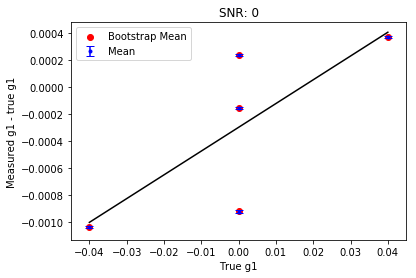

In [93]:
#y axis: measured shear - true shear. x-axis true shear
#Say for which SNR is this plot
#specify SNR through function
snr_index, measurement = 0,0
fitAndPlot(shearList,res,snr_index,measurement)
shear = (g1shear,g2shear)[measurement]
plt.scatter(shear,meanShearBootstrap[snr_index,:,measurement]-shear,c='r',label='Bootstrap Mean')
plt.legend()
print snrArr

Use more realistic distributions of flux and ellipticity. Can still calculate separately for each SNR but combine to get m for all snrs
use the 3 g2=0 points for m1 calc, vice versa for m2 calc
to look for cross term and x

weights = 1/(shape noise^2 + shape_err^2) 
shape_err is from estimate shear
shape noise: variance of ellipticities: for now input ellipticities
